In [1]:
import sys, os
sys.path.append( os.path.join( '..', 'src' ) ) # set path to project src/

In [60]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [3]:
from utils import kaggle_io, kaggle_reader

In [4]:
# first define home path as kaggle_nuclei/, i.e., one level up from kaggle_nuclei/notebooks
homepath = os.path.join('..')
# define path for the kaggle csv file
f = os.path.join(homepath,'data','raw','stage1_train_labels.csv')
# define path for the unzipped training image folder
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')

In [17]:
# load csv file and decode the nuclei pixel locations for use later
decodedlabels = kaggle_reader.read_kaggle_csv(f)
# load all the images into gray scale
imgDF = kaggle_reader.load_all_raw_images(impath, mode='L')

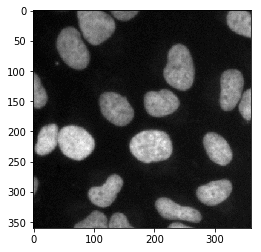

In [22]:
# example of one of the images
testimgId = np.random.choice(imgDF.ImageId)
plt.imshow(imgDF[imgDF.ImageId == testimgId].ImageMat.values[0], cmap='gray')

In [19]:
# find nuclei bounding box information
boxDF = kaggle_reader.find_mask_bounding_box(decodedlabels, imgDF)

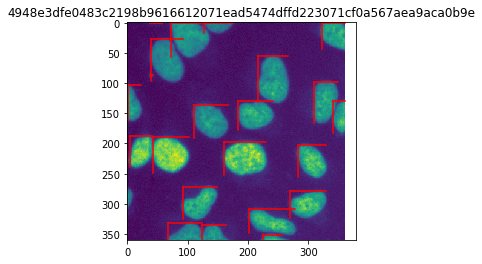

In [23]:
kaggle_reader.visual_check_boxes(boxDF, imgDF, testimgId)

In [21]:
boxDF = boxDF.assign(boxHoW = boxDF.boxH/boxDF.boxW)
boxDF[['boxH', 'boxW', 'boxHoW', 'imgW', 'imgH']].describe()

,boxH,boxW,boxHoW,imgW,imgH
count,29461.000000,29461.000000,29461.000000,29461.000000,29461.000000
mean,22.550287,22.929059,1.094878,404.408642,506.068090
std,13.619336,13.822146,0.951989,187.400013,282.185678
min,1.000000,1.000000,0.021277,256.000000,256.000000
25%,12.000000,13.000000,0.794521,256.000000,256.000000
50%,20.000000,21.000000,1.000000,360.000000,360.000000
75%,29.000000,29.000000,1.222222,520.000000,696.000000
max,139.000000,122.000000,57.000000,1040.000000,1388.000000


1. The images sizes and nuclei sizes varies a lot, especially the nuclei sizes
2. Nuclei shapes, indicated by the height over width ratio, 
3. The ratio between nuclei pixel values over non-nuclei pixel values varies a lot, but there is definitely a difference between those two.
4. The variations are both inter-images and intra-image
5. challenging to find reliable features to use in nuclei classifiers since the basic metrics, like size and pixel values, varies a lot.

In [210]:
def trim_extreme_pixels_in_grayscale(image_array, trim_left=1, trim_right=99):
    if trim_left and trim_right:
        min_val, max_val = np.percentile(image_array.ravel(), [trim_left, trim_right])
        image_array = np.maximum(min_val, np.minimum(max_val, image_array))
    elif trim_left and not trim_right:
        min_val = np.percentile(image_array.ravel(), trim_left)
        image_array = np.maximum(min_val, image_array)
    elif trim_right and not trim_left:
        max_val = np.percentile(image_array.ravel(), trim_right)
        image_array = np.minimum(max_val, image_array)
    else:
        pass
    
    return image_array

In [211]:
trimed_image = trim_extreme_pixels_in_grayscale(test_image, trim_left=None, trim_right=None)

In [44]:
trimed_images = imgDF.ImageMat.apply(trim_extreme_pixels_in_grayscale)

In [47]:
from skimage.exposure import rescale_intensity

In [49]:
norm_trimed_images = trimed_images.apply(rescale_intensity)

In [50]:
imgDF = imgDF.assign(NormTrim_ImageMat = norm_trimed_images)

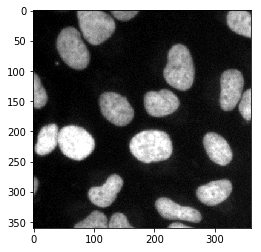

In [51]:
# example of one of the images
plt.imshow(imgDF[imgDF.ImageId == testimgId].NormTrim_ImageMat.values[0], cmap='gray')

In [53]:
np.min(imgDF[imgDF.ImageId == testimgId].NormTrim_ImageMat.values[0])

0.0

In [54]:
def isolate_nuclei_background_in_grayscale(imgid, decodedlabels, imgDF, image_data_name):
    """
    collects the pixel values (in gray scale) of nucleis and background (non-nuclei regions) in a single gray scale
    image
    :param imgid: the ImageId to work on
    :param decodedlabels: decoded pixel labels read from Kaggle csv and decoded (see utils/kaggle_reader.py)
    :param imgDF: dataframe of all the images, loaded by load_all_images in utils/kaggle_reader.py
    :return: two 1D arrays: first an array of pixel values for the nucleis, second an array of pixel values for the
            background
    """

    # find all the nucleis associated with the given image
    nucleis = decodedlabels[decodedlabels.ImageId == imgid].DecodedPixels.values
    # find the image data and ravel it in 1D format along the row (FORTRAN style)
    imgvec = (imgDF[imgDF.ImageId == imgid])[image_data_name].values[0]
    imgvec = imgvec.ravel(order='F')
    # initialize the list for pixel indices that are part of a nuclei
    all_nuclei_index = []
    for nuclei in nucleis:
        # add pixel indices from each nuclei to the common list
        all_nuclei_index.extend(nuclei)
    # generate a mask the same size of the raveled image vector where True = background and False = nuclei
    mask = np.ones(imgvec.shape, dtype=bool)
    mask[all_nuclei_index] = False
    return imgvec[~mask], imgvec[mask]

In [55]:
nucleivals, backgroundvals = isolate_nuclei_background_in_grayscale(testimgId, decodedlabels, imgDF, 'NormTrim_ImageMat')

Text(0.5,0,'pixel value (gray-scale)')

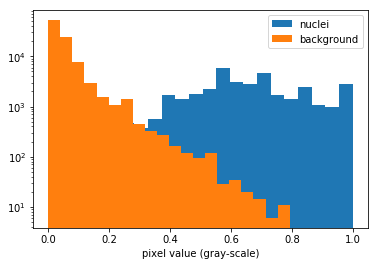

In [56]:
plt.hist(nucleivals, bins=20)
plt.hist(backgroundvals, bins=20)
plt.yscale('log', nonposy='clip')
plt.legend(['nuclei', 'background'])
plt.xlabel('pixel value (gray-scale)')

In [61]:
def gather_pixel_means(decodedlabels, imgDF, image_data_name):
    """
    Gathers the mean pixel value (in gray scale) of the nucleis and background in each image
    :param decodedlabels: decoded pixel labels read from Kaggle csv and decoded (see utils/kaggle_reader.py)
    :param imgDF: dataframe of all the images, loaded by load_all_images in utils/kaggle_reader.py
    :return: a dataframe containing the ImageId, mean pixel vale of all the nucleis in this image, and mean pixel values
            of the background in this image
    """

    # initialize the lists for mean pixel values and ImageID
    background_mean = []
    nuclei_mean = []
    imageids = []
    # iterate through all images, using ImageID (imgid) to identify each image
    for imgid in imgDF.ImageId:
        # acquire pixel values for the nucleis and background
        nucleivals, backgroundvals = isolate_nuclei_background_in_grayscale(imgid, decodedlabels, imgDF, image_data_name)
        # calculate the mean values
        background_mean.append(backgroundvals.mean())
        nuclei_mean.append(nucleivals.mean())
        # record the ImageId
        imageids.append(imgid)
    return pd.DataFrame(list(zip(imageids, nuclei_mean, background_mean)),
                        columns=['ImageId', 'nucleiMean', 'backgroundMean'])

In [62]:
pixelvalDF = gather_pixel_means(decodedlabels, imgDF, 'NormTrim_ImageMat')

In [63]:
pixelvalDF = pixelvalDF.assign(SNratio = pixelvalDF.nucleiMean/pixelvalDF.backgroundMean)
pixelvalDF.describe()

,nucleiMean,backgroundMean,SNratio
count,670.000000,670.000000,670.000000
mean,0.609501,0.201368,14.585987
std,0.204869,0.323171,10.404723
min,0.003919,0.012398,0.004359
25%,0.475702,0.033735,7.619424
50%,0.642438,0.046281,14.083515
75%,0.753195,0.077474,21.520468
max,1.000000,0.950762,55.997349


Text(0.5,0,'log10(nuclei pixel value/background pixel value)')

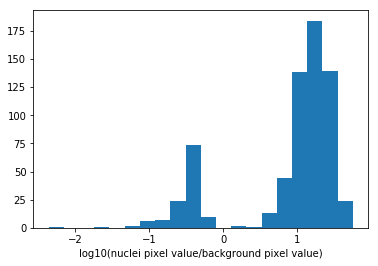

In [64]:
plt.hist(np.log10(pixelvalDF.SNratio), bins = 20)
plt.xlabel('log10(nuclei pixel value/background pixel value)')

Text(0.5,0,'pixel value (gray-scale)')

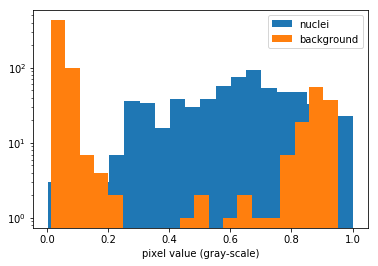

In [65]:
plt.hist(pixelvalDF.nucleiMean, bins=20)
plt.hist(pixelvalDF.backgroundMean, bins=20)
plt.yscale('log', nonposy='clip')
plt.legend(['nuclei', 'background'])
plt.xlabel('pixel value (gray-scale)')

(array([ 52653.,  24777.,  10757.,   1638.,   2224.,    826.,   1704.,
           995.,   2680.,   1891.,   2328.,   5839.,   3122.,   5508.,
          2116.,   3176.,   1316.,   2260.,    986.,   2804.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

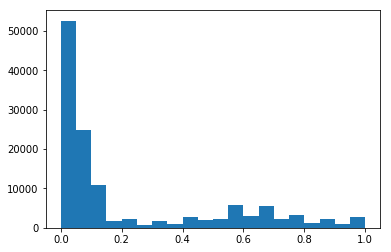

In [67]:
plt.hist(imgDF[imgDF.ImageId == testimgId].NormTrim_ImageMat.values[0].ravel(), bins=20)

In [86]:
def extract_total_mask(imgid, decodedlabels, image_shape):
    """
    collects the pixel values (in gray scale) of nucleis and background (non-nuclei regions) in a single gray scale
    image
    :param imgid: the ImageId to work on
    :param decodedlabels: decoded pixel labels read from Kaggle csv and decoded (see utils/kaggle_reader.py)
    :param imgDF: dataframe of all the images, loaded by load_all_images in utils/kaggle_reader.py
    :return: two 1D arrays: first an array of pixel values for the nucleis, second an array of pixel values for the
            background
    """

    # find all the nucleis associated with the given image
    nucleis = decodedlabels[decodedlabels.ImageId == imgid].DecodedPixels.values
    # initialize the list for pixel indices that are part of a nuclei
    all_nuclei_index = []
    for nuclei in nucleis:
        # add pixel indices from each nuclei to the common list
        all_nuclei_index.extend(nuclei)
    # generate a mask the same size of the raveled image vector where True = background and False = nuclei
    mask = np.zeros(np.prod(image_shape),)
    mask[all_nuclei_index] = 1
    return mask.reshape(image_shape, order='F')

In [82]:
from skimage.transform import resize

In [96]:
MAX_W = 256
MAX_H = 256
X = []
y = []
for i in range(len(imgDF)):
    image_shape = imgDF.iloc[i]['NormTrim_ImageMat'].shape
    X.append((imgDF.iloc[i])['NormTrim_ImageMat'][:MAX_H, :MAX_W].ravel(order='F'))
    mask = extract_total_mask(imgDF.iloc[i].ImageId, decodedlabels, image_shape)
    y.append(mask[:MAX_H, :MAX_W].ravel(order='F'))

In [78]:
imgDF.ImageMat.apply(np.shape).value_counts()

(256, 256)      334
(256, 320)      112
(520, 696)       92
(360, 360)       91
(1024, 1024)     16
(512, 640)       13
(603, 1272)       6
(260, 347)        5
(1040, 1388)      1
Name: ImageMat, dtype: int64

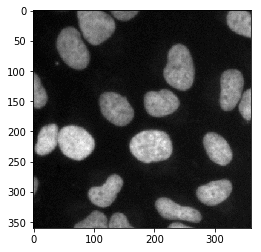

In [98]:
plt.imshow(imgDF[imgDF.ImageId == testimgId].ImageMat.values[0], cmap='gray')

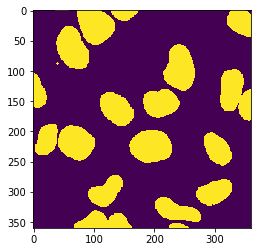

In [91]:
plt.imshow(extract_total_mask(testimgId, decodedlabels, imgDF[imgDF.ImageId == testimgId].ImageMat.values[0].shape))

In [94]:
imgDF.iloc[0]['NormTrim_ImageMat'].shape

(256, 256)

In [101]:
import sklearn.neural_network

In [229]:
idx_to_train = np.random.choice(len(X), 20)

In [230]:
classifer = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=0.00001, tol=1e-10, 
                                                 hidden_layer_sizes=(100, 50), random_state=1, verbose=True)

In [107]:
y = np.array(y)
y.shape

(670, 65536)

In [231]:
idx_to_train

array([157,  80,  40, 418,  50, 263, 175,  95, 175, 414, 360, 512, 490,
       648, 410, 500, 501, 647, 277, 497])

In [232]:
classifer.fit(X[idx_to_train[:10], :], y[idx_to_train[:10], :])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=1e-10, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [233]:
classifer.score(X[idx_to_train[:10], :], y[idx_to_train[:10], :])

0.29999999999999999

In [234]:
y_predict = classifer.predict(X[idx_to_train, :])

In [214]:
y_test_predict = classifer.predict(X[:10, :])

In [158]:
len(y_predict[0])

65536

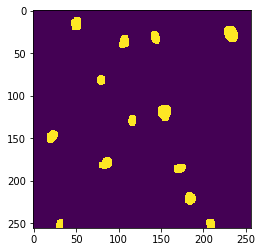

In [239]:
plt.imshow(y[idx_to_train[11]].reshape((MAX_H, MAX_W), order='F'))

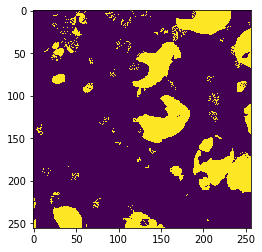

In [240]:
plt.imshow(y_predict[11].reshape((MAX_H, MAX_W), order='F'))

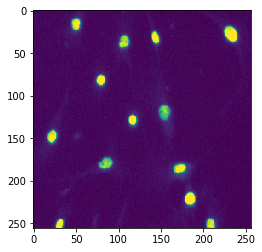

In [241]:
plt.imshow(X[idx_to_train[11]].reshape((MAX_H, MAX_W), order='F'))

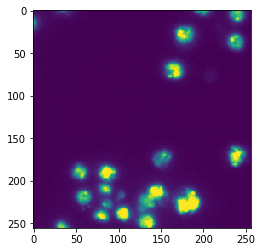

In [218]:
plt.imshow(X[0].reshape((MAX_H, MAX_W), order='F'))

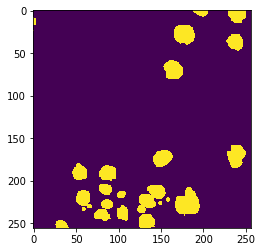

In [219]:
plt.imshow(y[0].reshape((MAX_H, MAX_W), order='F'))

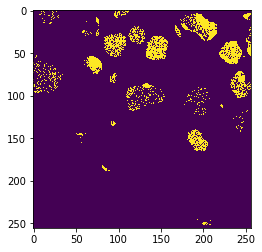

In [220]:
plt.imshow(y_test_predict[0].reshape((MAX_H, MAX_W), order='F'))

In [131]:
import skimage.morphology

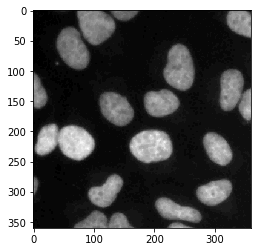

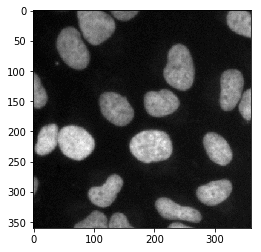

In [144]:
plt.imshow(skimage.morphology.closing(test_image, skimage.morphology.square(3)), cmap='gray')
plt.show()
plt.imshow(test_image, cmap='gray')

In [242]:
options = {'L': None, 'trim': [1, 99]}

In [248]:
if 'L' in options.keys():
    print(options['L'])

None


In [247]:
options.keys()

dict_keys(['L', 'trim'])

In [311]:
def process_image(image_array, options):
    """
    preprocesses image with all options available
    :param image_array: image data
    :param options: option dictionary
    :return: processed image
    """
    if 'rgb2gray' in options.keys():
        image_array = skimage.color.rgb2gray(image_array)
    if 'trim' in options.keys():
        if len(options['trim']) < 2:
            print('Must provide a list with two number for trimming. Recived: ', options['trim'])
        else:
            image_array = trim_extreme_pixels_in_grayscale(image_array,
                                                           trim_left=options['trim'][0],
                                                           trim_right=options['trim'][1])
    if 'norm' in options.keys():
        image_array = skimage.exposure.rescale_intensity(image_array)

    return image_array

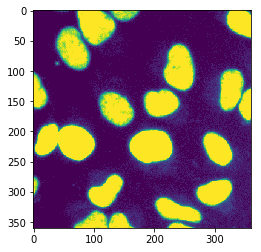

In [251]:
plt.imshow(process_image(test_image,{'trim': [20, 80]}))

In [312]:
test_train = pd.read_pickle('../data/small_roi/train_dataframe.pkl')

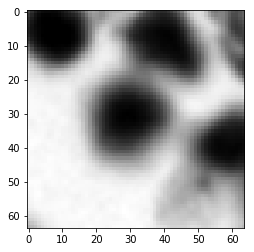

In [313]:
plt.imshow(test_train.iloc[26].image_matrix, cmap='gray')

In [268]:
test_train.iloc[26].image_matrix.shape

(64, 64)

In [271]:
def recover_box_size(box_anchor, box_shape, resized_image_shape, original_image_shape):
    """
    recover the box location in the original image from the resized image
    :param box_anchor: [upper-most row, left-most column]
    :param box_shape: (box height, box width)
    :param resized_image_shape:  (image height, image width)
    :param original_image_shape:  (image height, image width)
    :return: box anchor and shape in original image
    """
    # first calculate the scaling factor in the two dimensions
    scale_factors = np.array(original_image_shape) / np.array(resized_image_shape)
    # then apply the factor to the anchor and shape
    original_box_anchor = (np.array(box_anchor) * scale_factors).astype(int)
    original_box_shape = (np.array(box_shape) * scale_factors).astype(int)
    return original_box_anchor, original_box_shape

In [276]:
recover_box_size([0, 10], [64, 64], [256, 256], [400, 500])

(array([ 0, 19]), array([100, 125]))

In [286]:
import scipy.ndimage.filters

In [1]:
test = np.zeros(test_image.shape)
test[int(test_image.shape[0]/2)][int(test_image.shape[1]/2)] = 1
plt.imshow(scipy.ndimage.filters.gaussian_filter(test, 0.1), cmap='gray')

NameError: name 'np' is not defined

In [309]:
gaussian_peak = scipy.ndimage.filters.gaussian_filter(test, 100)

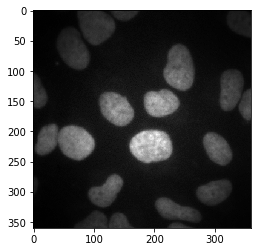

In [310]:
plt.imshow(gaussian_peak*test_image, cmap='gray')

In [315]:
from preprocess import image_processing

In [327]:
def gaussian_kernel_feature_extraction(image_array, gaussian_sigma_vec, preprocessing_options):
    central_peak = np.zeros(image_array.shape)
    central_peak[int(image_array.shape[0]/2)][int(image_array.shape[1]/2)] = 1
    # image_array = image_processing.somename(image_array, preprocessing_options)
    features = []
    for sigma in gaussian_sigma_vec:
        gaussian_peak = scipy.ndimage.filters.gaussian_filter(central_peak, sigma)
        features.append((gaussian_peak * image_array).sum())
    return features

In [329]:
gaussian_kernel_feature_extraction(test_image, np.arange(1,150), {})

[4.3241263488056889,
 4.1850261793538106,
 4.1980110268165998,
 4.2601933216968133,
 4.379607691026643,
 4.6003771345067506,
 4.9503157532521289,
 5.4232956950967326,
 5.9908548090937543,
 6.6182494125210045,
 7.2739516013485357,
 7.9326606969277655,
 8.575526079348295,
 9.1889831206723365,
 9.7635620443127795,
 10.293089613920046,
 10.773916622567132,
 11.204185066253606,
 11.583565257552765,
 11.912967426752214,
 12.194091870122854,
 12.429238263299307,
 12.621194522076301,
 12.77307536362806,
 12.888205920043273,
 12.970041086330822,
 13.022047477294549,
 13.047619143759137,
 13.050038281739887,
 13.032404445253636,
 12.997609704652731,
 12.948352157739912,
 12.887119345877242,
 12.816122570769338,
 12.737320411379752,
 12.652490417516983,
 12.563183582224793,
 12.470717853015923,
 12.376256209952595,
 12.280812957267221,
 12.18525056261166,
 12.090272630799879,
 11.996476915475258,
 11.904342731957737,
 11.814256405083935,
 11.726529054369429,
 11.64141045418789,
 11.55907943617496

In [330]:
from utils import kaggle_io

In [331]:
image = kaggle_io.png_to_pixel_matrix('../data/raw/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')

In [332]:
from analysis import moving_window

In [333]:
subimages = moving_window.extract_windowed_subimages_from_image(image, [64,64], [5,5])

In [334]:
from analysis import feature_extractions

In [340]:
import importlib
importlib.reload(feature_extractions)
importlib.reload(image_processing)

<module 'preprocess.image_processing' from '..\\src\\preprocess\\image_processing.py'>

In [341]:
image_dataframe = pd.read_pickle('../data/roi/train/tiny_train_roi_dataframe.pkl')

In [342]:
features = feature_extractions.feature_extraction(image_dataframe,
                                                  input_parameters='image_matrix',
                                                 method='gkhp',
                                                 extraction_options=[2,4,8,16,32,64,128,200],
                                                 image_process_options={'L': None})

In [343]:
len(features)

382

In [348]:
features[191]

array([ 16.89538769,  20.27812886,  33.78665116,  49.32218339,
        48.51171163,  48.49032484,  48.49283615,  48.4929497 ])

In [347]:
image_dataframe[image_dataframe.is_positive=='0'].is_positive

191    0
192    0
193    0
194    0
195    0
196    0
197    0
198    0
199    0
200    0
201    0
202    0
203    0
204    0
205    0
206    0
207    0
208    0
209    0
210    0
211    0
212    0
213    0
214    0
215    0
216    0
217    0
218    0
219    0
220    0
      ..
352    0
353    0
354    0
355    0
356    0
357    0
358    0
359    0
360    0
361    0
362    0
363    0
364    0
365    0
366    0
367    0
368    0
369    0
370    0
371    0
372    0
373    0
374    0
375    0
376    0
377    0
378    0
379    0
380    0
381    0
Name: is_positive, Length: 191, dtype: object

In [349]:
import sklearn.externals.joblib

In [411]:
importlib.reload(moving_window)

<module 'analysis.moving_window' from '..\\src\\analysis\\moving_window.py'>

In [353]:
import scipy.misc

In [421]:
test_image = scipy.misc.imread('../data/small_split/test_image.png', mode='RGB')

In [422]:
classifier = sklearn.externals.joblib.load('../models/neural_network_adam_200_100_nobuffer.pkl')

Extracting sub images
Extracting features
Running prediction
                0             1
count  625.000000  6.250000e+02
mean     0.759078  2.409218e-01
std      0.231985  2.319848e-01
min      0.000222  5.249886e-08
25%      0.563104  1.013471e-02
50%      0.806607  1.933933e-01
75%      0.989865  4.368959e-01
max      1.000000  9.997775e-01


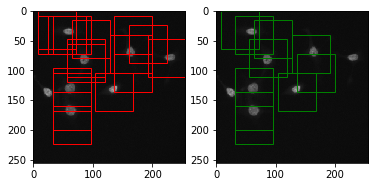

In [423]:
moving_window.run_moving_window(classifier, test_image, 'pixelval', [64, 64], [8, 8], 0.7)

In [424]:
classifier = sklearn.externals.joblib.load('../models/svm_sigmoid_C10000_neg32_prob.pkl')

Extracting sub images
Extracting features
Running prediction
                0           1
count  625.000000  625.000000
mean     0.608142    0.391858
std      0.002772    0.002772
min      0.607367    0.365017
25%      0.607367    0.392625
50%      0.607367    0.392633
75%      0.607375    0.392633
max      0.634983    0.392633


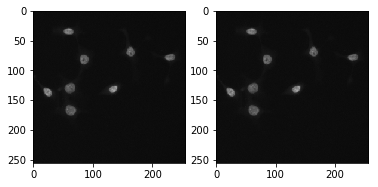

In [425]:
moving_window.run_moving_window(classifier, test_image, 'hog', [64, 64], [8, 8], 0.7)

In [366]:
test_image.shape

(256, 320, 3)

In [368]:
256-64-64

128

In [378]:
np.arange(0, 321-64, 64)

array([  0,  64, 128, 192, 256])

In [379]:
320%64

0

In [384]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

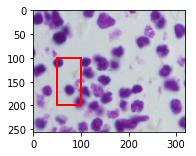

In [391]:
fig = plt.figure(1)
ax = fig.add_subplot(121)
ax.imshow(test_image)

rect = patches.Rectangle((50,100), 50, 100, linewidth=2, edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [427]:
image_dataframe.iloc[0].image_matrix.shape

(64, 64, 3)